# Markov Chain Analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils
from msci.utils.utils import data_path
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn, plot_histogram_jn, plot_points_on_map_jn
from msci.analysis.markov_chain import *

In [4]:
from sklearn import preprocessing
from scipy.stats import linregress

## Get data

In [5]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [7]:
shop_df_old = utils.import_shop_directory(mall='Mall of Mauritius', version=2)

In [8]:
shop_df1 = utils.import_shop_directory(mall='Mall of Mauritius', version=1)

shop_df = pd.merge(
    shop_df_old, 
    shop_df1[['store_id', 'store_name', 'store_category']], 
    how='left',
    on='store_id'
)

In [9]:
r_signal_df1 = signal_df[
    signal_df.store_id.notnull() & 
    (signal_df.store_id.str[0] == 'B') & 
    signal_df.mac_address.isin(shopper_df.mac_address)
].sort_values(['mac_address', 'date_time'])

In [10]:
r_signal_df = pd.merge(
    r_signal_df1, 
    shop_df[['store_id', 'store_category']], 
    how='left', 
    on='store_id'
)

r_signal_df.store_category[r_signal_df.store_category.isnull()] = 'None'

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Markov Chain

In [11]:
names, A, pi = markov_chain(r_signal_df, return_permitted=False, on='store_id')

In [26]:
shop_probs_df = process_t(names, A.T, pi, shop_df, rep = 1000)
shop_probs_df.head()

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers,store_name,store_category,pi,piA,ss
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744,Intermart,Supermarket,0.062773,0.014445,0.063943
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661,Courts Mammouth,Audio/Electronic,0.051985,0.025274,0.035048
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464,Cash & Carry,Audio/Electronic,0.019394,0.017909,0.025072
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449,Manjoo,Home & Décor,0.027083,0.026745,0.039245
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711,Monoprix,Supermarket,0.023984,0.014893,0.015764


In [27]:
# # Output transition matrix and shop names
output = False

if output:
    np.savez(
        data_path + 'shop_markov_data', 
        shop_names=names,
        transition_matrix=A,
        initial_probabilities=pi,
    )

In [28]:
def add_count_of_shoppers(signal_df, shop_df):
    count_of_shoppers = []
    signal_group = signal_df.groupby('store_id')
    for shop in tqdm(shop_df.store_id.tolist(), desc='Count of shoppers'):
        try:
            group = signal_group.get_group(shop)
            count_of_shoppers.append(len(group.mac_address.unique()))
        except:
            count_of_shoppers.append(np.nan)
    return count_of_shoppers

In [29]:
shop_probs_df['act_count'] = add_count_of_shoppers(signal_df, shop_df)

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

In [45]:
area_shop_df = shop_probs_df[
    (shop_probs_df.area > 5) & 
    (shop_probs_df.pi > 0) & 
    (shop_probs_df.act_count > 400)
]

In [46]:
area_shop_df

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers,store_name,store_category,pi,piA,ss,act_count
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744,Intermart,Supermarket,0.062773,0.014445,0.063943,15744
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661,Courts Mammouth,Audio/Electronic,0.051985,0.025274,0.035048,6661
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464,Cash & Carry,Audio/Electronic,0.019394,0.017909,0.025072,4464
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449,Manjoo,Home & Décor,0.027083,0.026745,0.039245,5449
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711,Monoprix,Supermarket,0.023984,0.014893,0.015764,4711
5,22243,B219,443.333333,"{153.5: [23.0, 28.5], 133.0: [16.0, 16.0], 134...","[158.00708837237184, 24.718982751127694]",158.007088,24.718983,7294,Spur,Food,0.076084,0.022549,0.030813,7294
6,21695,B46,906.000000,"{116.5: [140.5, 142.0], 125.0: [135.0, 150.0],...","[136.18202350772069, 139.51823768917566]",136.182024,139.518238,6318,Woolworths,Clothing,0.033624,0.014837,0.035875,6318
7,21135,B245,504.833333,"{229.66666666666663: [47.0, 54.333333333333343...","[228.10487343269457, 47.608035643876661]",228.104873,47.608036,1901,Samsung,Audio/Electronic,0.010213,0.032617,0.009309,1901
8,17784,B77,676.000000,"{280.5: [96.5, 107.0], 259.0: [99.0, 99.0], 26...","[270.49156545209178, 103.09851551956815]",270.491565,103.098516,4474,Go Sport,Specialist,0.013886,0.023624,0.030327,4474
9,15162,B37,335.500000,"{102.5: [113.5, 120.0], 103.5: [106.5, 120.0],...","[104.83943411159477, 110.61146286769555]",104.839434,110.611463,2694,Allsport,Clothing,0.010099,0.015635,0.018095,2694


In [53]:
csfont = {'fontname':'Times New Roman'}
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Times New Roman',style='normal', size=20)

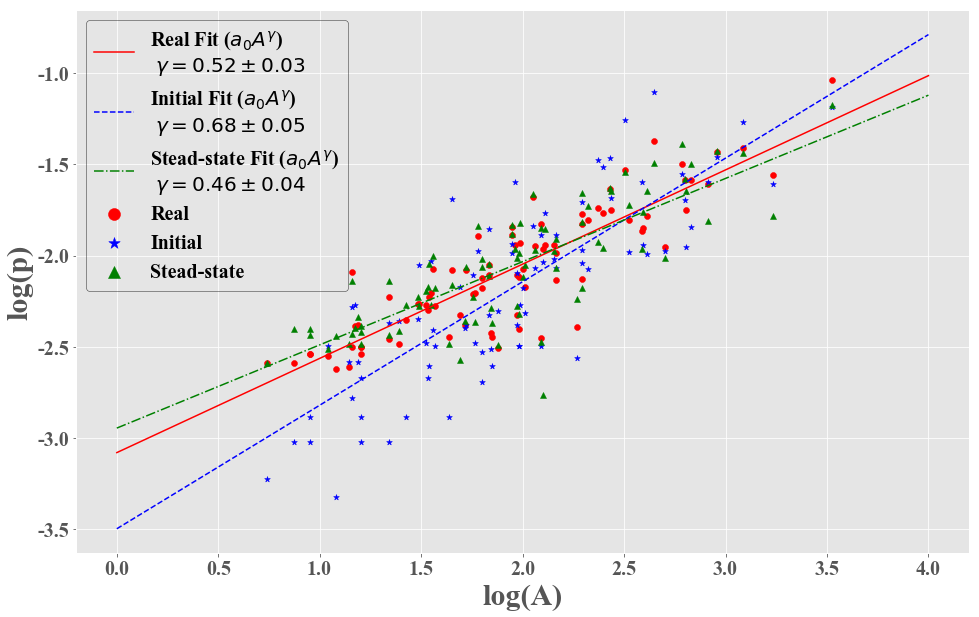

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.act_count / sum(area_shop_df.act_count)).tolist())
ax.scatter(x, y, c='r', label='Real', marker='o')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'r-', 
    label='Real Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.pi / sum(area_shop_df.pi)).tolist())
ax.scatter(x, y, c='b', label='Initial', marker='*')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'b--', 
    label='Initial Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.ss / sum(area_shop_df.ss)).tolist())
ax.scatter(x, y, c='g', label='Stead-state', marker='^')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'g-.', 
    label='Stead-state Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('log(A)', fontsize=30, **csfont)
ax.set_ylabel('log(p)', fontsize=30, **csfont)
ax.legend(markerscale=2., prop=font, frameon=True, edgecolor='k', facecolor='none')
ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticks(), csfont)
ax.set_yticklabels(ax.get_yticks(), csfont);
# ax.set_xscale('log')
# ax.set_yscale('log')

## Transition matrix network

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_numpy_matrix(A[:20, :20], create_using=nx.MultiDiGraph())
G = nx.relabel_nodes(G, dict(enumerate(le.inverse_transform(range(len(pi[:20]))))))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
labels = {i : i for i in G.nodes()}
pos=nx.spring_layout(G)
nx.draw(G, pos=pos, ax=ax)
nx.draw_networkx_labels(G, pos=pos, labels=labels);

In [ ]:
def remove_duplicate_stores():
    signal_mac_group = r_signal_df.groupby('mac_address')
    mac_addresses = r_signal_df.mac_address.unique()

    dd_signal = pd.DataFrame()

    for macs in tqdm(mac_addresses):
        seq = signal_mac_group.get_group(macs)
        if len(seq) > 1:
            sel = np.ones(len(seq), dtype=bool)
            seq_store = seq.store_id.as_matrix()
            sel[1:] = seq_store[1:] != seq_store[:-1]
            seq = seq[sel]
        dd_signal = pd.concat([dd_signal, seq])
        
    return dd_signal


test = remove_duplicate_stores()
# dd_signal_df = pd.concat(dd_signal)

In [ ]:
dd_signal_df = test

In [ ]:
dd_signal_df.head()

In [ ]:
K = 2
D = 16

pi=np.zeros(K)
b=np.zeros((2, D))
A=np.ones((2, D, D))

names, A[0], b[0] = markov_chain(
    dd_signal_df[dd_signal_df.mac_address.isin(shopper_df[shopper_df.length_of_stay < 4000].mac_address[:500])], 
    return_permitted=True, 
    on='store_category'
)

names, A[1], b[1] = markov_chain(
    dd_signal_df[dd_signal_df.mac_address.isin(shopper_df[shopper_df.length_of_stay > 11000].mac_address[500:])], 
    return_permitted=True, 
    on='store_category'
)

pi=np.array([0.5, 0.5])

In [ ]:
b.round(2)

In [ ]:
np.diag(A[0])

In [ ]:
A[0][0]

In [ ]:
names, pi, b, A, gamma = markov_chain_clustering(dd_signal_df, pi, b, A, 1)

In [ ]:
plt.hist(gamma[0], bins=100);

In [ ]:
names, A_all, b_all = markov_chain(
    dd_signal_df, 
    return_permitted=True, 
    on='store_category'
)

In [ ]:
shop_categories_df = pd.DataFrame.from_records({'store_categories': names, 'pi': b_all})
shop_categories_count_df = pd.DataFrame(shop_df.store_category.value_counts().reset_index())
shop_categories_count_df.columns = ['store_categories', 'frequency']
shop_categories_df = pd.merge(shop_categories_df, shop_categories_count_df, how='left', on='store_categories')

In [ ]:
b_all = shop_categories_df.pi.as_matrix()
b_allA = A_all.T.dot(b_all).tolist()
shop_categories_df['piA'] = b_allA

In [ ]:
b_all = shop_categories_df.pi.as_matrix()

for i in range(100):
    b_all = A_all.T.dot(b_all).tolist()
    
shop_categories_df['ss'] = b_all

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

values = shop_categories_df[
    shop_categories_df.frequency.notnull() &
    shop_categories_df.pi.notnull()
]

x = np.log10(values.frequency.tolist())
y = np.log10(values.pi.tolist())
ax.scatter(x, y, c='r', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**0, 10**1.5, 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'r--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(values.frequency.tolist())
y = np.log10(values.piA.tolist())
ax.scatter(x, y, c='b', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**0, 10**1.5, 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'b--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(values.frequency.tolist())
y = np.log10(values.ss.tolist())
ax.scatter(x, y, c='g', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**0, 10**1.5, 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'g--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store (A) [$m^2$]', fontsize=15)
ax.set_ylabel('Probability of shopper in shop ($p(A)$)', fontsize=15)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=15);

In [ ]:
shop_categories_df.sort_values('ss')